In [20]:
import io
import zipfile
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import os

from sklearn.metrics import accuracy_score, f1_score


Artículos válidos: 1604

Distribución de veracidad:
veracity
mostly true                  1249
mixture of true and false     209
mostly false                   82
no factual content             64
Name: count, dtype: int64

Distribución de orientación:
orientation
mainstream    822
right         530
left          252
Name: count, dtype: int64


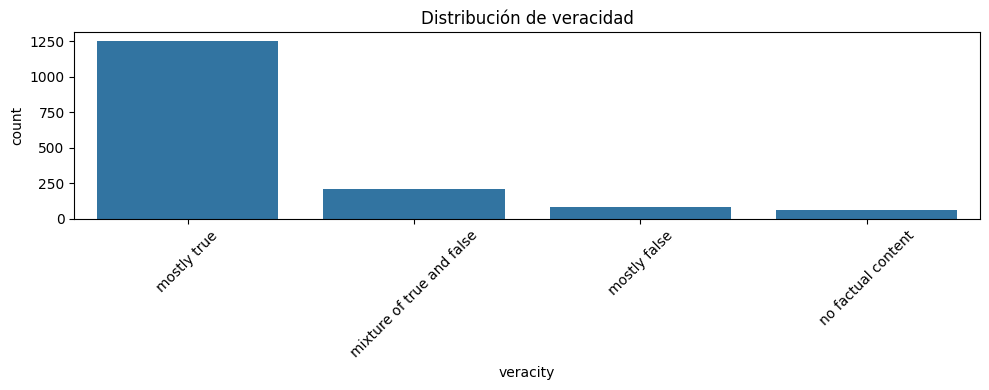

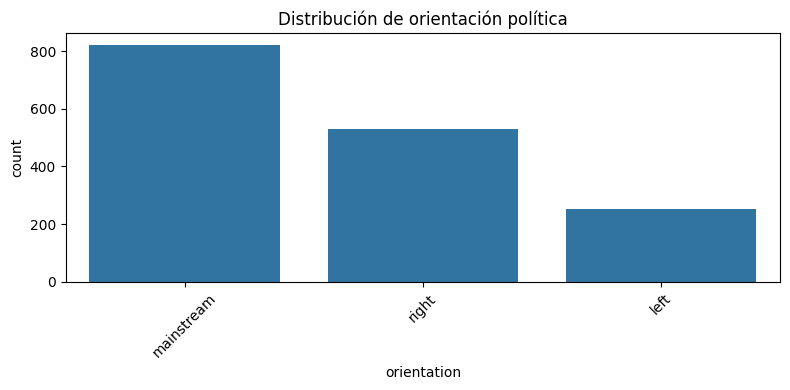


Vectorización completada. Tamaño del vocabulario: 11458


In [21]:
# Paso 1: Leer archivos XML desde la carpeta "articles/"
data = {"mainText": [], "orientation": [], "veracity": []}
for filename in os.listdir("articles/"):
    if filename.endswith(".xml"):
        root = ET.parse(f"articles/{filename}").getroot()
        for elem in root:
            if elem.tag in data.keys():
                data[elem.tag].append(elem.text)

# Paso 2: Crear DataFrame y eliminar filas incompletas
data = pd.DataFrame(data)
data = data[data.notna().all(axis="columns")]

# Paso 3: Análisis exploratorio
print(f"Artículos válidos: {len(data)}")

print("\nDistribución de veracidad:")
print(data["veracity"].value_counts())

print("\nDistribución de orientación:")
print(data["orientation"].value_counts())

# Gráficos
plt.figure(figsize=(10, 4))
sns.countplot(data=data, x="veracity", order=data["veracity"].value_counts().index)
plt.title("Distribución de veracidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=data, x="orientation", order=data["orientation"].value_counts().index)
plt.title("Distribución de orientación política")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Paso 4: Separar en train/test
X_train, X_test, y_train, y_test = train_test_split(
    data["mainText"],
    data["veracity"],
    test_size=0.2,
    random_state=42
)

# Paso 5: Preprocesamiento con CountVectorizer
vectorizer = CountVectorizer(
    lowercase=True,
    stop_words="english",
    max_df=0.6,
    min_df=3
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"\nVectorización completada. Tamaño del vocabulario: {len(vectorizer.vocabulary_)}")


# 🔍 Clasificación con **Multinomial Naive Bayes**

El clasificador **Multinomial Naive Bayes (MNB)** es un modelo probabilístico que se basa en la fórmula de Bayes, bajo el supuesto de independencia condicional entre características dado el valor de la clase.

Este modelo es especialmente adecuado para problemas con datos representados como **conteos discretos**, como el caso del modelado de texto con bolsas de palabras (Bag-of-Words).

El objetivo es modelar:

$$
p(y \mid \mathbf{x}) \propto p(y) \cdot \prod_{j=1}^{V} \theta^{(y)}_j{}^{x_j}
$$

donde:
- $ y $ es una clase posible.
- $ \mathbf{x} = (x_1, \dots, x_V) $ es el vector de conteos de términos (como en una bolsa de palabras).
- $ \theta^{(y)}_j $ es la probabilidad de la palabra $ j $ dado que el documento es de clase $ y $.

---

## 🎓 Fundamento teórico

Según las filminas, el modelo asume que los datos se generan como:

$$
\mathbf{N} \mid Y = k \sim \text{Multinomial}(d^{(k)}, \theta^{(k)}),
$$

donde:
- $ \mathbf{N} = (N_1, \dots, N_V) $ es el vector de conteos para un documento.
- $ \theta^{(k)} \sim \text{Dir}(\alpha) $ es una distribución Dirichlet que regulariza las probabilidades de palabras.
- $ d^{(k)} $ es la suma de ocurrencias en todos los documentos de clase $ k $.

El estimador bayesiano para los parámetros es:

$$
\hat{\theta}^{(k)}_j = \frac{N^{(k)}_j + \alpha}{\sum_m N^{(k)}_m + V \cdot \alpha}
$$

Y la inferencia se realiza mediante:

$$
\log p(y \mid \mathbf{x}) \propto \log p(y) + \sum_j x_j \cdot \log \theta^{(y)}_j
$$

---

## ⚙️ Clase `MNB`

Se implementó una clase `MNB` que encapsula el entrenamiento y predicción con el clasificador Multinomial Naive Bayes, utilizando suavizado de Laplace (Dirichlet uniforme).

### **Inicialización**

Para inicializar el modelo se utiliza:

**MNB(alpha=1.0)**

donde `alpha` es el parámetro de suavizado que regulariza las probabilidades $ \theta^{(y)}_j $.

---

### `fit(X, y)`

Entrena el modelo con:
- `X`: matriz de conteos (documentos x palabras).
- `y`: vector de etiquetas (una por documento).

Durante el entrenamiento:
- Se estima la **probabilidad a priori** de cada clase:
  
  $$
  \log p(y = k) = \log \frac{\#\text{docs con clase } k}{\text{total de docs}}
  $$

- Se acumulan los conteos totales por clase y se estima:

  $$
  \log \theta^{(k)}_j = \log \left( \frac{\text{ocurrencias de la palabra } j \text{ en clase } k + \alpha}{\text{total de palabras en clase } k + V \cdot \alpha} \right)
  $$

---

### `predict(X)`

Devuelve las clases predichas para cada documento (fila de `X`), eligiendo:

$$
\hat{y} = \arg\max_y \left[ \log p(y) + \sum_j x_j \log \theta^{(y)}_j \right]
$$

---

### `predict_proba(X)`

Devuelve la **distribución de probabilidad** sobre las clases para cada documento:

$$
p(y \mid \mathbf{x}) = \frac{e^{\text{score}_y}}{\sum_{y'} e^{\text{score}_{y'}}}
$$

donde `score_y` es el logaritmo de la probabilidad no normalizada.

---

### `score(X, y)`

Devuelve el **accuracy** sobre el conjunto de evaluación:

$$
\frac{\# \text{predicciones correctas}}{\# \text{total de ejemplos}}
$$

---

### `macro_f1(X, y)`

Devuelve el **F1 macro** promedio entre clases, penalizando la clase desbalanceada. Se usa:

$$
\text{Macro-F1} = \frac{1}{K} \sum_{k=1}^K \text{F1-score}_k
$$

---

## 📊 Aplicación típica

Este modelo es comúnmente utilizado en:
- Clasificación de texto (spam vs. ham, noticias, opiniones).
- Análisis de sentimientos.
- Detección de temas.

Gracias a su simplicidad y efectividad, MNB es un gran modelo base para tareas donde los datos son representaciones de **frecuencias de tokens discretos**.


In [22]:
class MNB:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.classes_ = None
        self.class_log_prior_ = None
        self.feature_log_prob_ = None

    def fit(self, X, y):
        """
        Entrena el modelo MNB con smoothing de Dirichlet
        """
        y = np.array(y)
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_features = X.shape[1]

        # Inicializar contadores
        class_counts = np.zeros(n_classes)
        feature_counts = np.zeros((n_classes, n_features))

        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]
            class_counts[idx] = X_c.shape[0]
            feature_counts[idx, :] = X_c.sum(axis=0)  # Ñ^{(k)}_m

        # Estimación de log(c_y)
        self.class_log_prior_ = np.log(class_counts / class_counts.sum())

        # Smoothing + estimación bayesiana
        smoothed_fc = feature_counts + self.alpha  # Ñ^{(k)}_m + α
        smoothed_totals = smoothed_fc.sum(axis=1).reshape(-1, 1)  # d̃^{(k)} + Σα
        self.feature_log_prob_ = np.log(smoothed_fc / smoothed_totals)  # log(θ^{(k)}_m)

    def predict_log_proba(self, X):
        return X @ self.feature_log_prob_.T + self.class_log_prior_

    def predict_proba(self, X):
        log_prob = self.predict_log_proba(X)
        log_prob -= log_prob.max(axis=1, keepdims=True)  # para estabilidad numérica
        prob = np.exp(log_prob)
        return prob / prob.sum(axis=1, keepdims=True)

    def predict(self, X):
        log_prob = self.predict_log_proba(X)
        return self.classes_[np.argmax(log_prob, axis=1)]

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def macro_f1(self, X, y):
        y_pred = self.predict(X)
        return f1_score(y, y_pred, average="macro", zero_division=0)



mnb = MNB()
mnb.fit(X_train_vec, y_train)

# Predicción dura y soft
y_pred = mnb.predict(X_test_vec)
y_proba = mnb.predict_proba(X_test_vec)

print("Predicciones:", y_pred[:5])
print("Probabilidades (1ra muestra):", y_proba[0])


Predicciones: ['mostly true' 'mostly true' 'mixture of true and false' 'mostly true'
 'mostly true']
Probabilidades (1ra muestra): [6.04586236e-064 6.73739152e-106 1.00000000e+000 3.74922217e-074]


In [23]:
acc = mnb.score(X_test_vec, y_test)
f1 = mnb.macro_f1(X_test_vec, y_test)

print(f"Accuracy en test: {acc:.4f}")
print(f"Macro-F1 en test: {f1:.4f}")

Accuracy en test: 0.7352
Macro-F1 en test: 0.4140


## 📈 Análisis de Resultados del Modelo MNB

Tras entrenar un clasificador **Multinomial Naive Bayes** sobre el texto de los artículos (`mainText`) para predecir su nivel de veracidad (`veracity`), se evaluó el desempeño del modelo en un conjunto de testeo, obteniendo los siguientes resultados:

- **Accuracy**: 0.7352  
- **Macro-F1**: 0.4140

### 🔍 Interpretación

- El **accuracy** indica que el modelo acierta aproximadamente el **73,5%** de las predicciones. A simple vista, puede parecer un buen desempeño.
- Sin embargo, la métrica de **Macro-F1** (0.41) revela una limitación importante: el modelo no está prediciendo correctamente todas las clases por igual.

### ⚠️ Impacto del desbalance de clases

Al observar la distribución de las etiquetas de veracidad, se nota que la gran mayoría de los artículos (casi el 80%) están etiquetados como *"mostly true"*. Esto significa que un modelo podría alcanzar una alta exactitud simplemente prediciendo siempre esa clase, sin aprender realmente a diferenciar entre casos más sutiles o engañosos.

La **Macro-F1** penaliza este comportamiento al promediar el F1-score de cada clase por igual, independientemente de su frecuencia. Un valor bajo en esta métrica sugiere que el modelo tiene dificultades para identificar correctamente las clases minoritarias, como *"mostly false"* o *"no factual content"*.

---

### 💡 Conclusión

Si bien el modelo MNB capta patrones generales del lenguaje en artículos mayormente verdaderos, su capacidad para distinguir entre los distintos matices de veracidad es limitada. Este resultado pone en evidencia la necesidad de:

- Mejorar la representación de las clases menos frecuentes.
- Aplicar técnicas de balanceo (sobremuestreo, pesos por clase).
- Explorar modelos más robustos o combinaciones de enfoques para lograr una clasificación más equilibrada.


In [24]:
# 1. Redefinimos las etiquetas
y_train_ori = y_train.index.map(data["orientation"])  # usar la orientación de cada muestra original
y_test_ori = y_test.index.map(data["orientation"])

# A veces el index cambia tras el split, lo mejor es regenerar desde df directamente:
X_ori = data["mainText"]
y_ori = data["orientation"]

X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(
    X_ori,
    y_ori,
    test_size=0.2,
    random_state=42
)

# 2. Vectorizamos el texto (usamos el mismo CountVectorizer que antes, o podés regenerarlo)
X_train_vec_o = vectorizer.fit_transform(X_train_o)
X_test_vec_o = vectorizer.transform(X_test_o)

# 3. Entrenamos el clasificador
mnb_ori = MNB()
mnb_ori.fit(X_train_vec_o, y_train_o)

# 4. Evaluamos
acc_o = mnb_ori.score(X_test_vec_o, y_test_o)
f1_o = mnb_ori.macro_f1(X_test_vec_o, y_test_o)

print(f"[Orientación política]")
print(f"Accuracy en test: {acc_o:.4f}")
print(f"Macro-F1 en test: {f1_o:.4f}")


[Orientación política]
Accuracy en test: 0.8193
Macro-F1 en test: 0.7700


## 🗳️ Análisis de Resultados del Modelo MNB — Orientación Política

En este experimento se entrenó un modelo **Multinomial Naive Bayes (MNB)** para predecir la **orientación política** de los artículos a partir de su texto (`mainText`). Las clases posibles eran:

- `left`
- `right`
- `mainstream`

### 📊 Resultados obtenidos

Evaluado sobre un conjunto de testeo, el modelo alcanzó:

- **Accuracy**: 0.8193  
- **Macro-F1**: 0.7700

### 🔍 Interpretación

- El **accuracy** del 81.9% indica que el modelo acierta en una proporción muy alta de ejemplos. 
- Más importante aún, el **Macro-F1** de 0.77 sugiere que el modelo está funcionando **de forma balanceada** entre las diferentes clases, incluso considerando que algunas son menos frecuentes (por ejemplo, `left`).

Esto representa una mejora significativa respecto al experimento con la etiqueta `veracity`, y sugiere que el modelo es capaz de **capturar diferencias lingüísticas relevantes entre artículos de distintas orientaciones políticas**.

---

### 💡 Conclusión

El clasificador Multinomial Naive Bayes aplicado a la tarea de predicción de orientación política muestra un rendimiento **fuerte y consistente**. Esto indica que el estilo y el contenido textual de los artículos contiene suficiente información para que el modelo distinga entre posiciones políticas.

A futuro se podría complementar este análisis con:

- Visualización de las palabras más informativas por clase.
- Comparación con modelos más complejos (como SVM o redes neuronales).
- Evaluación en subconjuntos específicos (por ejemplo, sólo artículos `mostly true`).

Esto permitiría no solo mejorar el rendimiento, sino también **interpretar mejor qué señales lingüísticas están usando los modelos para discriminar entre ideologías**.
